# Loading Packages

In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import ipywidgets as widgets # for dropdown
import folium

# Read in the Data

We are using a subset of the parking violations data, specifically just the data from 2022 since the original file is extremeley large. Here, we read in and reformat the data, turning it into a GeoDataFrame in order to create map plots later on, as well as add an additional column specifying the day of the week of each citation.

In [2]:
# reading in data and visualizing first few rows

df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

Citation Number Citation Issued DateTime  Violation Violation Description  \
0       950226616      2022-04-20 12:10:00  TRC7.2.22             STR CLEAN   
1       952126114      2022-06-17 16:12:00  TRC7.2.20                RES/OT   
2       950441903      2022-04-23 15:13:00      V5200             NO PLATES   
3       948460144      2022-02-22 11:54:00  TRC7.2.20                RES/OT   
4       948169644      2022-02-17 13:39:00  TRC7.2.20                RES/OT   

  Citation Location Vehicle Plate State Vehicle Plate  Fine Amount  \
0   1318 FILBERT ST                  CA       V507699         84.0   
1   1318 FILBERT ST                  CA       BV44D97         96.0   
2   1318 FILBERT ST                  CA       V507699        121.0   
3   1318 FILBERT ST                  TX       HVT6737         96.0   
4   1318 FILBERT ST                  OH       HQA6554         96.0   

               Date Added                                            geom  
0  05/01/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
1  07/17/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
2  05/18/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
3  05/23/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
4  04/03/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)

In [3]:
# converts to GeoDataFrame for map plots. takes about 30 seconds

df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [4]:
# converting to datetime

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

In [5]:
# add a column for just day

df['citation_day'] = df['Citation Issued DateTime'].dt.day_name()

# Basic EDA

### Exploring number of tickets relative to different time scales

1. Number of tickets per month:

Text(0.5, 1.0, 'Number of Citations Each Month of 2022')

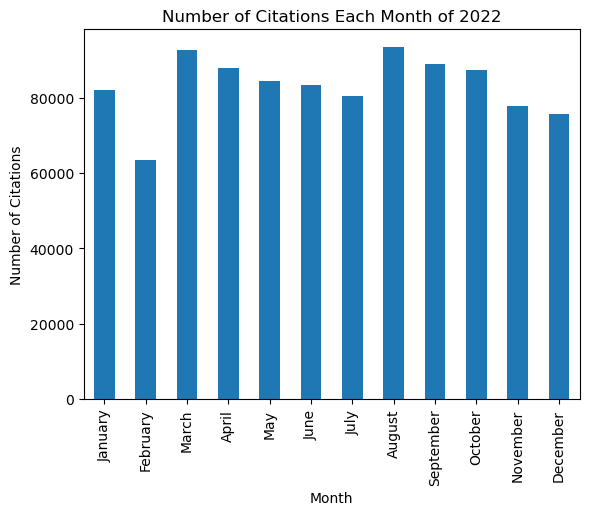

In [25]:
# tickets by month

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df2022 = df[df['Citation Issued DateTime'] < pd.to_datetime('2022-12-31')]
df2022['Citation Issued DateTime'].dt.month_name().value_counts().loc[months].plot.bar()
plt.xlabel("Month")
plt.ylabel("Number of Citations")
plt.title("Number of Citations Each Month of 2022")

We see that the number of citations is highest in March, steadily decreasing until fall. This trend repeats from August to December.

2. Number of tickets by day of the week: 

<AxesSubplot: >

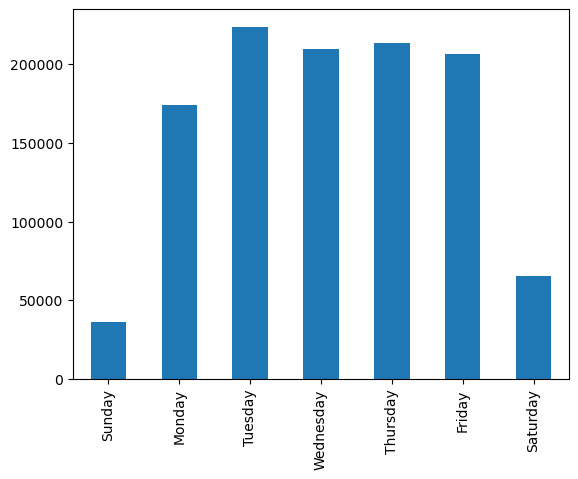

In [7]:
# tickets by day of the week

days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
df['Citation Issued DateTime'].dt.day_name().value_counts().loc[days].plot.bar()

There are noticably less citations on the weekends, as well as on Mondays. This may be due to free parking on the weekends, and the fact that street cleaning usually occurs during the week (we see later that street cleaning is the most common parking violation).

3. Number of tickets by hour of the day:

<AxesSubplot: >

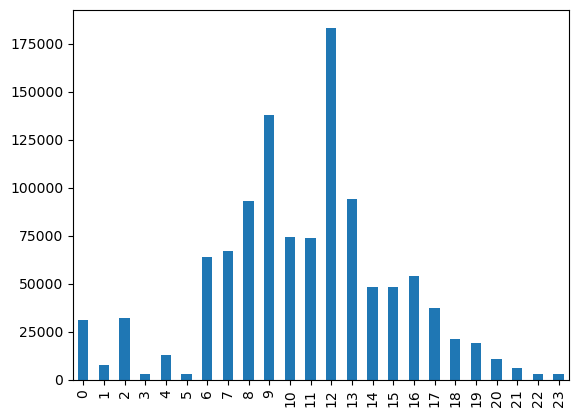

In [8]:
# tickets by hour of the day

df['Citation Issued DateTime'].dt.hour.value_counts().loc[range(0, 24)].plot.bar()

There are huge spikes of parking violations occurring at 9:00am and 12:00pm, which correspond to the times when people typically get to work or park for lunch.

Another perspective of the third plot:

/var/folders/b7/y91htkqs5jn2g1znl4ghlk1r0000gn/T/ipykernel_8799/2710839047.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  jan_citations = num_citations_day[num_citations_day.index < pd.to_datetime('2022-02-01')]


<AxesSubplot: >

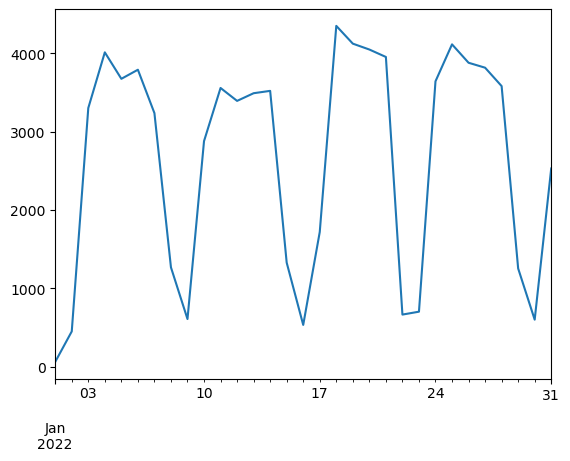

In [9]:
# plot number of citations by day, we see a highly cyclic trend. 

num_citations_day = df['Citation Issued DateTime'].dt.date.value_counts()
jan_citations = num_citations_day[num_citations_day.index < pd.to_datetime('2022-02-01')]
new_idx = pd.date_range(min(jan_citations.index), max(jan_citations.index))
jan_citations.reindex(new_idx, fill_value=0).plot(kind='line')

We see that the large dips correspond to the weekends, and the peaks in each cycle correspond to Tuesday. We saw these same trends in the previous plot of tickets by day of the week.

## Exploring the most common violations

STR CLEAN     4.458400e-01
MTR OUT DT    1.078056e-01
RES/OT        9.816110e-02
METER DTN     5.258374e-02
REG TABS      3.494675e-02
                  ...     
DBL PKG       8.867709e-07
ABAND. VEH    8.867709e-07
NO STOP BP    8.867709e-07
BK CHG BAY    8.867709e-07
IMP DPL PL    8.867709e-07
Name: Violation Description, Length: 116, dtype: float64

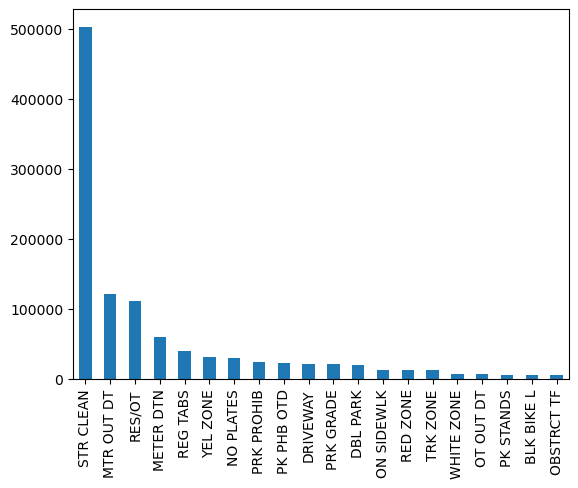

In [10]:
# bar plot of violation frequency in descending order. by far street cleaning is the biggest violation.

df['Violation Description'].value_counts().head(n=20).plot(kind='bar')
df['Violation Description'].value_counts(normalize=True)

By far, the largest parking violation is parking during street cleaning, making up 44.5% of all parking violations. MTR OUT DT refers to a ticket received for not paying for the meter in a non-downtown location, which accounts for the next 10.8% of parking violations, with RES/OT (illegally parking in a residential area) accounting for the next 9.8%.

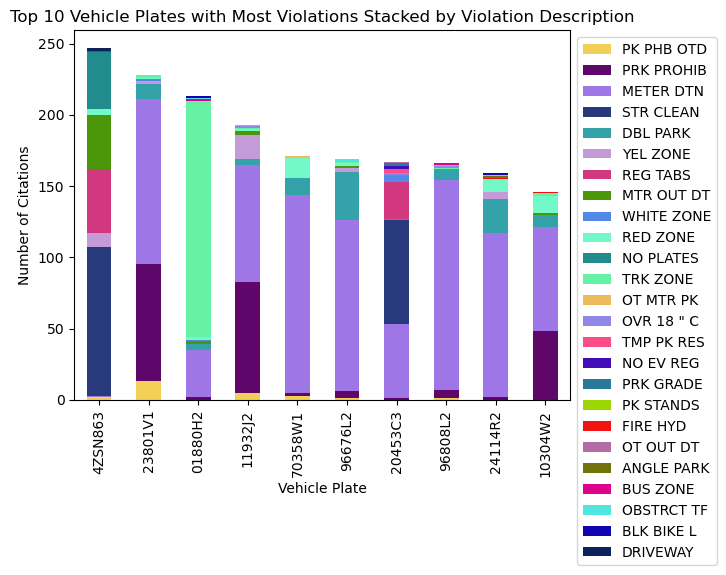

In [11]:
# top 10 people with most citations and their most common citation descriptions

# dataframe filtered to the info with top 10 vehicles
top_plates = df[df["Vehicle Plate"].isin(df["Vehicle Plate"].value_counts().head(10).index.tolist())]
top_plates = top_plates[["Vehicle Plate", "Violation Description"]]


# list of unique violation descriptions
cats = top_plates["Violation Description"].unique().tolist()
plates = pd.crosstab(top_plates['Vehicle Plate'], pd.Categorical(top_plates['Violation Description'], categories=cats, ordered=True))
plates = pd.crosstab(top_plates['Vehicle Plate'], top_plates['Violation Description']).reindex(columns=cats).reset_index()

# creating random colors (number is number of distinct violations)
random.seed(432)
no_of_colors=len(cats)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(no_of_colors)]

# order of plates from highest amount of citations to lowest
ord = df["Vehicle Plate"].value_counts().head(10).index.tolist()

plates.set_index("Vehicle Plate").loc[ord].plot(kind='bar', stacked=True,
        title='Top 10 Vehicle Plates with Most Violations Stacked by Violation Description', color = color)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Number of Citations")
plt.show()

This plot displays the top ten vehicle plates with the most citations, specifying the number of each type of citation per car. We can see the majority of the cars in this plot were most affected by downtown meter violations.

In [12]:
# map of where top 10 most common violations occurred

top10_vio = df["Violation Description"].value_counts().head(10).index.tolist()
df_top10 = df[df["Violation Description"].isin(top10_vio)]
df_top10 = df_top10.loc[:, df_top10.columns != "Citation Issued DateTime"]
df_top10.sample(10000).explore("Violation Description")

This map shows the locations of the top ten most common parking violations.

### Exploring the most citations by location

In [13]:
# top 10 areas with the most citations

num_citations_by_location = df['Citation Location'].value_counts()
gb_first = df.groupby('Citation Location').nth(0)

citation_df = gpd.GeoDataFrame(pd.merge(num_citations_by_location, gb_first, left_index=True, right_on='Citation Location'), geometry='geom')
citation_df.rename({'Citation Location': 'citation_count'}, axis=1, inplace=True)
citation_df.head(n=10)['citation_count']

Citation Location
501 TERRY A FRANCOIS BLVD         1424
993 POTRERO AVE                    589
200 CHANNEL ST                     575
492 CASTRO ST                      519
100 SPEAR ST                       444
300 FREMONT ST                     420
501 TERRY A FRANCOIS BOULEVARD     406
3252 PIERCE ST                     380
EMBARCADERO STATION                343
500 HOWARD ST                      331
Name: citation_count, dtype: int64

<AxesSubplot: xlabel='Citation Location'>

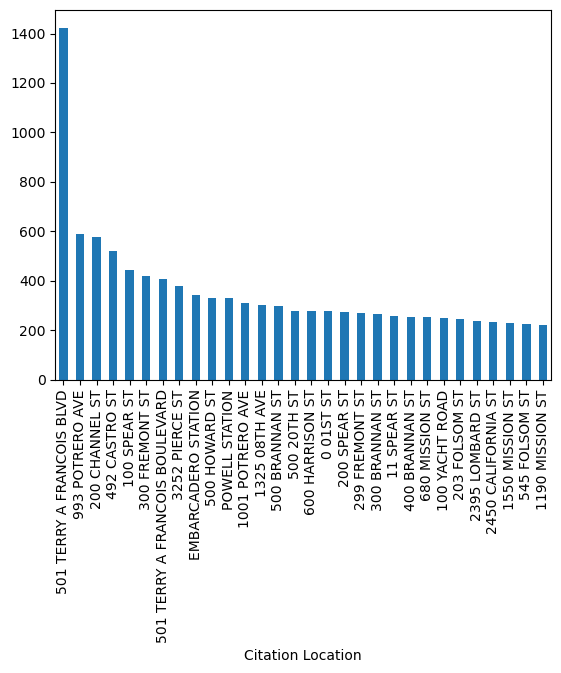

In [14]:
# bar plot of top 30 areas with the most citations

citation_df.head(n=30)['citation_count'].plot(kind='bar')

In [15]:
neighborhoods = gpd.read_file('../data/sf_neighborhoods.geojson')
citation_neighborhoods = df.sjoin(neighborhoods, how="left")
citation_neighborhoods.name.value_counts().head(n=20)

Mission                    80377
South of Market            70411
Tenderloin                 48711
Pacific Heights            38891
Financial District         37721
Lower Nob Hill             30624
Outer Richmond             26899
Outer Sunset               26512
Potrero Hill               26136
Marina                     24380
Inner Richmond             23386
Mission Bay                22371
Northern Waterfront        20641
Civic Center               20099
North Beach                20060
Union Street               19844
Mission Dolores            18874
Noe Valley                 18306
Downtown / Union Square    18006
Dolores Heights            17545
Name: name, dtype: int64

In [16]:
n_df = neighborhoods.set_index('name')
n_df['num_citations'] = citation_neighborhoods.name.value_counts()
n_df.explore(column='num_citations')

### Exploring Revenue

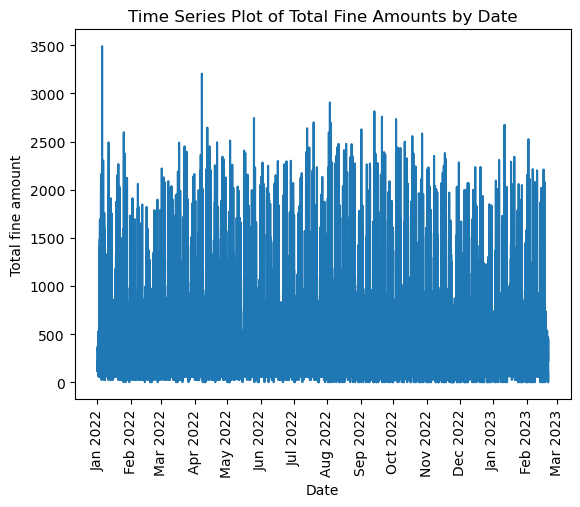

In [17]:
# Group data by date and sum the fine amounts
grouped_data = df.groupby('Citation Issued DateTime')['Fine Amount'].sum()

# Plot the time series
fig, ax = plt.subplots()
ax.plot(grouped_data.index, grouped_data.values)

# Set x-axis tick locator and formatter for months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total fine amount')
plt.title('Time Series Plot of Total Fine Amounts by Date')
plt.xticks(rotation=90)
plt.show()

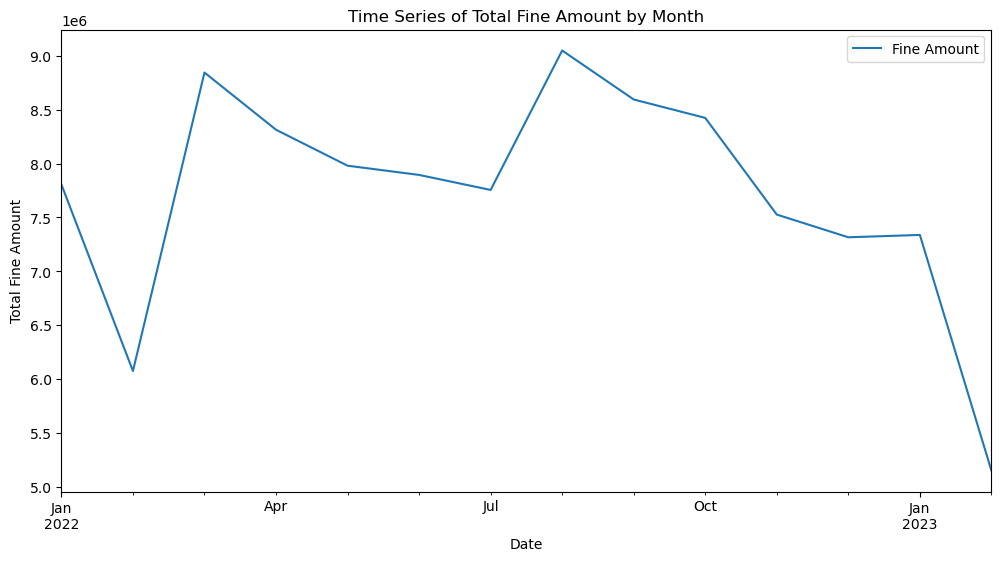

In [18]:
# this is too messy to see any trends, so let's do monthly average
grouped_month_df = df.groupby(pd.Grouper(key='Citation Issued DateTime', freq='M'))['Fine Amount'].sum().reset_index()

grouped_month_df.plot(x='Citation Issued DateTime', y='Fine Amount', figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Month')
plt.show()

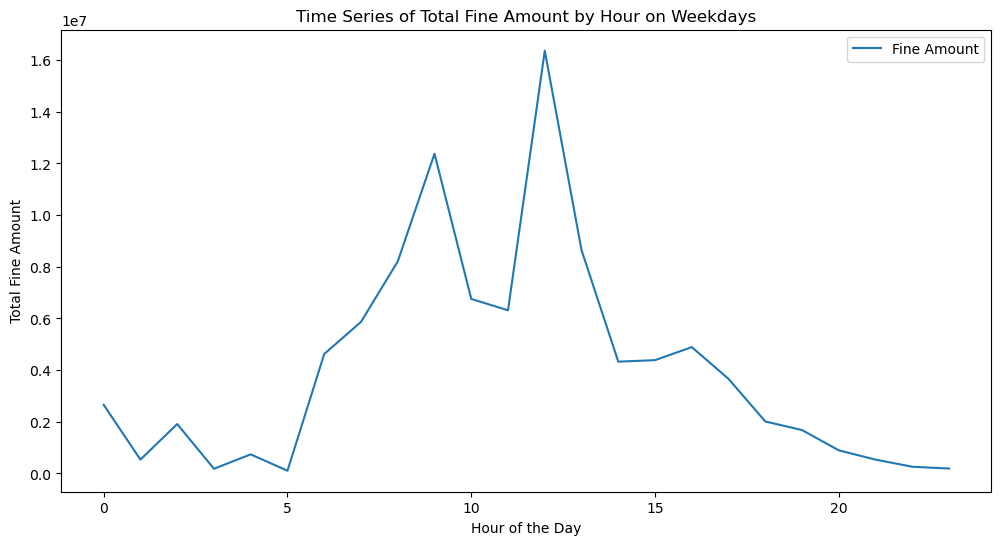

In [19]:
# Now stratify by days of the week.
df['Day of Week'] = df['Citation Issued DateTime'].dt.day_name()

# adding an hour column
df['hour'] = df['Citation Issued DateTime'].dt.hour

# filtering by weekday
grouped_weekday_df = df[df['Day of Week'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])]

# summing by hour
grouped_weekday_df = grouped_weekday_df.groupby('hour')['Fine Amount'].sum().reset_index()

# plot
grouped_weekday_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekdays')
plt.show()

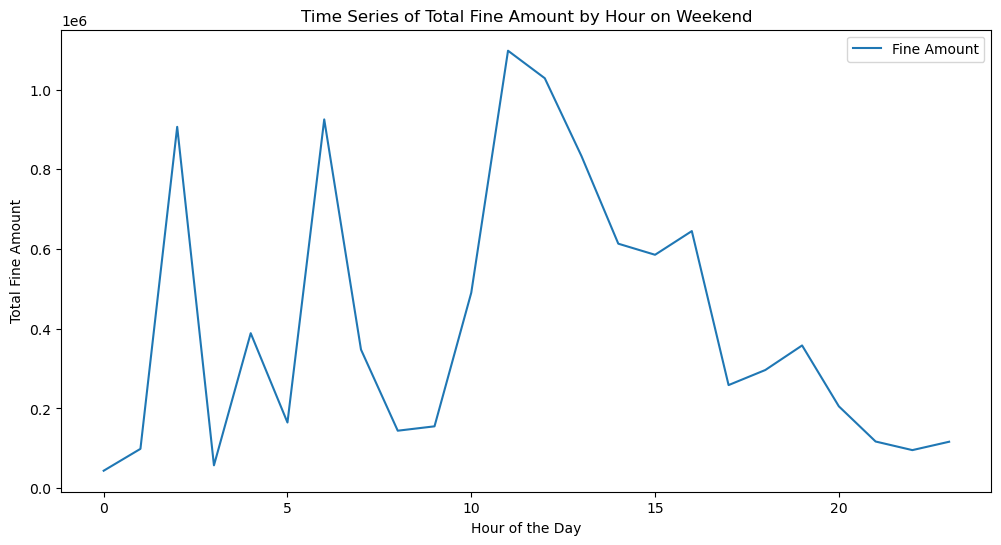

In [20]:
# filtering by weekend
grouped_weekend_df = df[df['Day of Week'].isin(["Saturday","Sunday"])]

# summing by hour
grouped_weekend_df = grouped_weekend_df.groupby('hour')['Fine Amount'].sum().reset_index()

# plot
grouped_weekend_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekend')
plt.show()

### Dropdown Map By Day of Week, With Top 10 Violations

In [21]:
# Now stratify by days of the week.
df['Day of Week'] = df['Citation Issued DateTime'].dt.day_name()

# plot first 10000 citation locations
top10_vio = df["Violation Description"].value_counts().head(10).index.tolist()
df_top10 = df[df["Violation Description"].isin(top10_vio)]

In [22]:
days_vec = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

map_list = []

for i in range(7):
    df_top_10_temp = df_top10.loc[df['Day of Week']==days_vec[i]] 
    df_top_10_temp = df_top_10_temp.loc[:, df_top_10_temp.columns != "Citation Issued DateTime"]
    day_plot = df_top_10_temp.head(n = 10000).explore("Violation Description")
    map_list.append(day_plot)

In [23]:
# Define the location and zoom level for the maps
location = [37.7749, -122.4194]
zoom_level = 13

# Create the dropdown menu
dropdown = widgets.Dropdown(
    options= days_vec,
    value='Monday',
    description='Select Map:'
)

# Create the maps
maps = []
for i in range(7):
    map_list[i].add_child(folium.Marker(location=location, popup=f"Map {i+1} Marker"))
    maps.append(map_list[i])

# Define the callback function to update the displayed map when the dropdown value is changed
def update_map(*args):
    selected_map = dropdown.value
    if selected_map == 'Monday':
        displayed_map.children = [widgets.HTML(maps[0]._repr_html_())]
    elif selected_map == 'Tuesday':
        displayed_map.children = [widgets.HTML(maps[1]._repr_html_())]
    elif selected_map == 'Wednesday':
        displayed_map.children = [widgets.HTML(maps[2]._repr_html_())]
    elif selected_map == 'Thursday':
        displayed_map.children = [widgets.HTML(maps[3]._repr_html_())]
    elif selected_map == 'Friday':
        displayed_map.children = [widgets.HTML(maps[4]._repr_html_())]
    elif selected_map == 'Saturday':
        displayed_map.children = [widgets.HTML(maps[5]._repr_html_())]
    elif selected_map == 'Sunday':
        displayed_map.children = [widgets.HTML(maps[6]._repr_html_())]

# Initialize the dropdown
dropdown.observe(update_map, 'value')

# Display the initial map
displayed_map = widgets.VBox([widgets.HTML(maps[0]._repr_html_())])

# Display the dashboard
dashboard = widgets.VBox([dropdown, displayed_map])
display(dashboard)